In [1]:
import os
import imageio.v2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
train_data_path = '/content/500 images'
num_lightfields = 125
num_cameras_x = 2
num_cameras_y = 2
height, width = 1024, 1024

In [3]:
class LightfieldDataset(Dataset):
    def __init__(self, data_path, num_lightfields, num_cameras_x, num_cameras_y):
        self.num_lightfields = num_lightfields
        self.num_cameras_x = num_cameras_x
        self.num_cameras_y = num_cameras_y
        self.data_path = data_path

    def __len__(self):
        return self.num_lightfields

    def __getitem__(self, idx):
        lightfield = torch.zeros(3, height // 2, width // 2, self.num_cameras_y, self.num_cameras_x)
        for x in range(self.num_cameras_x):
            for y in range(self.num_cameras_y):
                img_path = os.path.join(self.data_path, f'image{idx}_x{x}_y{y}.png')
                if not os.path.exists(img_path):
                    raise FileNotFoundError(f"File non trovato: {img_path}")
                view = Image.open(img_path).resize((width // 2, height // 2))
                view = torch.Tensor(np.array(view)).permute(2, 0, 1) / 255.0
                lightfield[:, :, :, y, x] = view
        lightfield = lightfield.view(3, height // 2, width // 2, -1).permute(3, 1, 2, 0)
        return lightfield

In [4]:
train_dataset = LightfieldDataset(data_path=train_data_path, num_lightfields=num_lightfields, num_cameras_x=num_cameras_x, num_cameras_y=num_cameras_y)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1)

In [5]:
input_shape = (num_cameras_y * num_cameras_x, height  // 2, width  // 2, 3)
input_img = layers.Input(shape=input_shape)

# Encoder
x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
encoded = layers.Conv3D(3, (3, 3, 3), activation='relu', padding='same')(x)

# Decoder
x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling3D((1, 2, 2))(x)
x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling3D((1, 2, 2))(x)
x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling3D((1, 2, 2))(x)
decoded = layers.Conv3D(3, (3, 3, 3), activation='sigmoid', padding='same')(x)

# Modello Autoencoder
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
train_data = []
for lf in train_loader:
    train_data.append(lf.numpy())
train_data = np.concatenate(train_data, axis=0)
train_data = train_data.reshape(-1, num_cameras_y * num_cameras_x, height // 2, width // 2, 3)

train_data = train_data.astype(np.float32)

Epoch 1/500
125/125 - 42s - 333ms/step - loss: 0.0194
Epoch 2/500
125/125 - 26s - 212ms/step - loss: 0.0077
Epoch 3/500
125/125 - 27s - 218ms/step - loss: 0.0062
Epoch 4/500
125/125 - 27s - 214ms/step - loss: 0.0054
Epoch 5/500
125/125 - 27s - 213ms/step - loss: 0.0049
Epoch 6/500
125/125 - 27s - 215ms/step - loss: 0.0048
Epoch 7/500
125/125 - 27s - 215ms/step - loss: 0.0044
Epoch 8/500
125/125 - 27s - 214ms/step - loss: 0.0042
Epoch 9/500
125/125 - 27s - 214ms/step - loss: 0.0041
Epoch 10/500
125/125 - 27s - 214ms/step - loss: 0.0040
Epoch 11/500
125/125 - 27s - 215ms/step - loss: 0.0039
Epoch 12/500
125/125 - 27s - 215ms/step - loss: 0.0038
Epoch 13/500
125/125 - 27s - 214ms/step - loss: 0.0038
Epoch 14/500
125/125 - 27s - 214ms/step - loss: 0.0037
Epoch 15/500
125/125 - 27s - 214ms/step - loss: 0.0037
Epoch 16/500
125/125 - 27s - 214ms/step - loss: 0.0036
Epoch 17/500
125/125 - 27s - 214ms/step - loss: 0.0036
Epoch 18/500
125/125 - 27s - 214ms/step - loss: 0.0035
Epoch 19/500
125/12

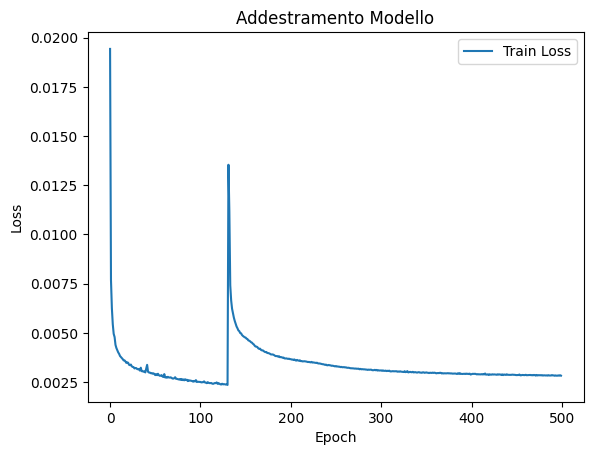

In [7]:
history = autoencoder.fit(train_data, train_data, epochs=500, batch_size=1, verbose=2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Addestramento Modello')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Dimensione delle immagini di partenza: (1, 4, 512, 512, 3)
Dimensione delle immagini compresse: (1, 4, 64, 64, 3)
Dimensione delle immagini decompresse: (1, 4, 512, 512, 3)
Peso della Light Field Image originale: 12288.00 KB
Peso della Light Field Image compressa: 192.00 KB
Peso della Light Field Image ricostruita: 12288.00 KB
Rapporto di compressione Light Field Image: 98.44%
Peso della singola immagine originale: 3072.00 KB
Peso della singola immagine compressa: 48.00 KB
Peso della singola immagine ricostruita: 3072.00 KB



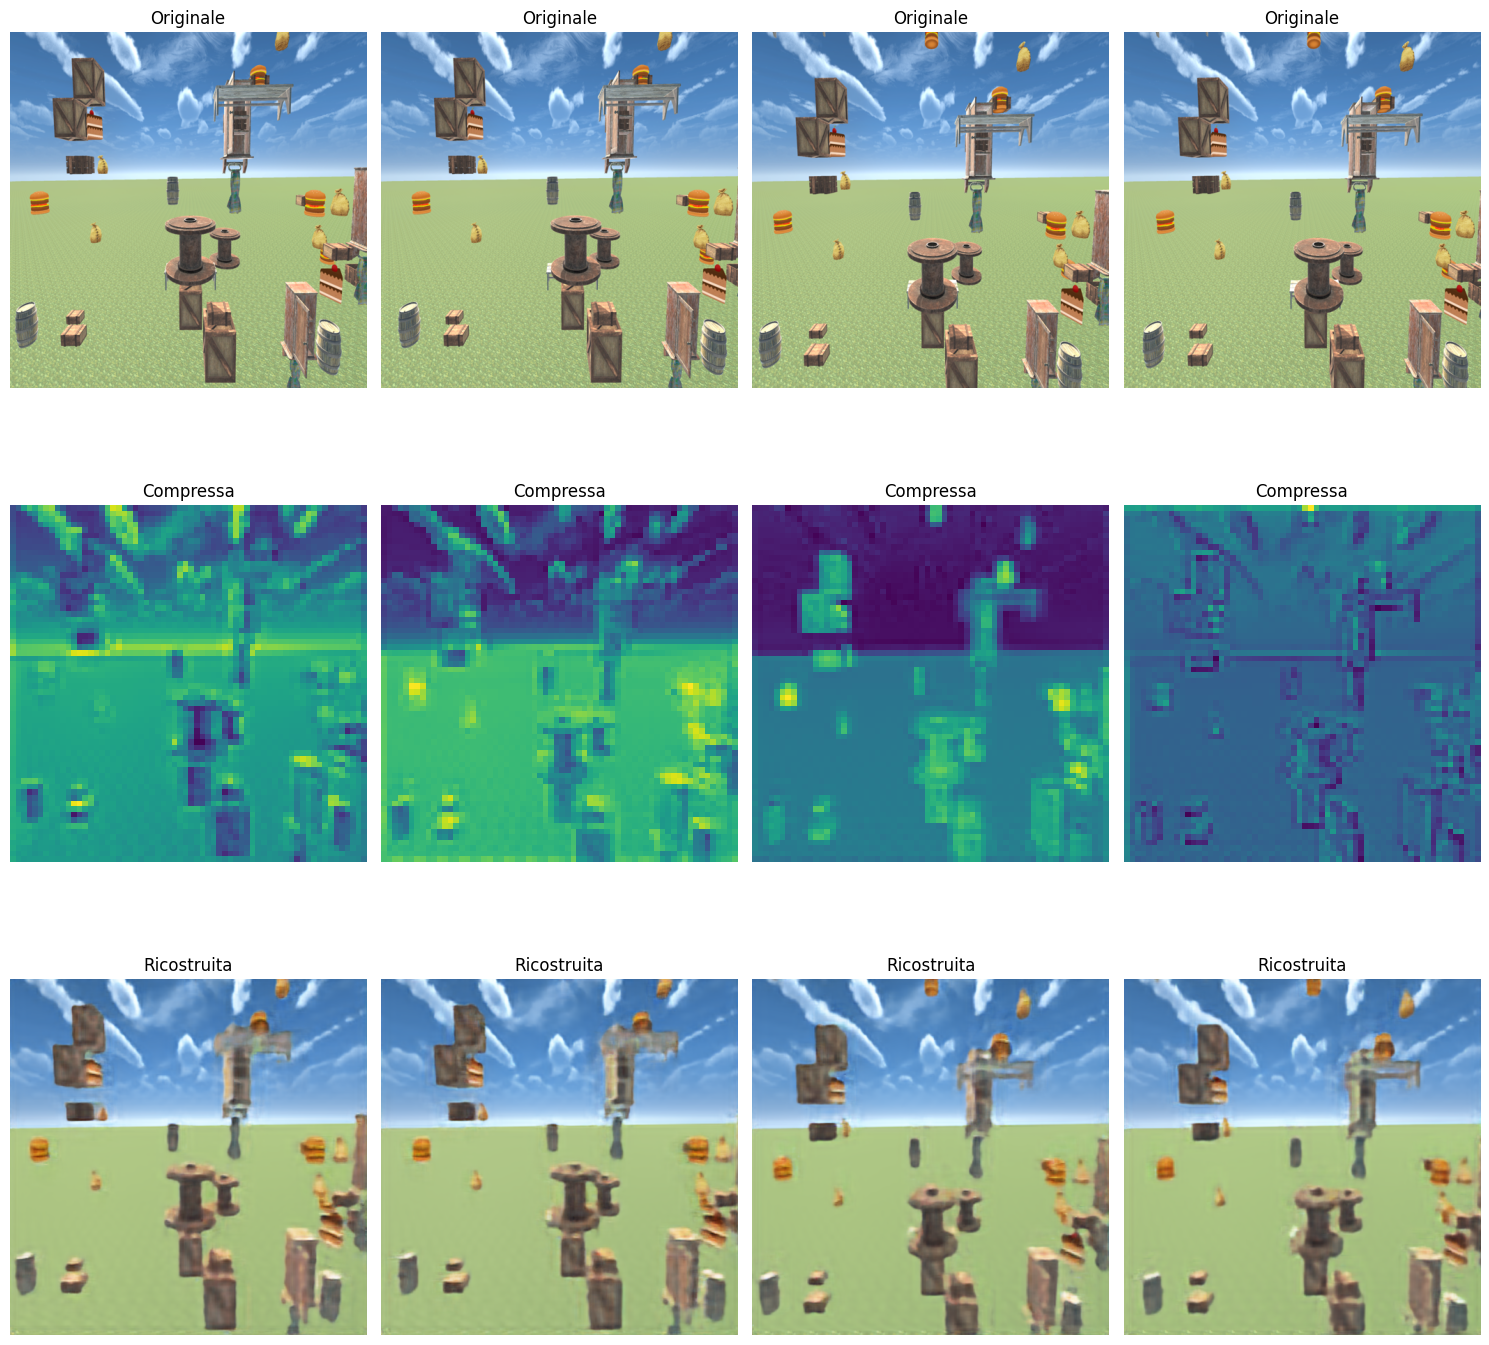

In [8]:
def visualize_reconstruction_and_compression(model, dataloader, num_images=4):
    encoder = models.Model(inputs=model.input, outputs=model.get_layer(index=len(model.layers)//2).output)
    decoder = models.Model(inputs=model.get_layer(index=len(model.layers)//2).output, outputs=model.output)

    fig, axs = plt.subplots(3, num_images, figsize=(15, 15))

    for batch in dataloader:
        batch_np = batch.numpy()

        compressed = encoder.predict(batch_np)
        reconstructed = decoder.predict(compressed)

        print(f"Dimensione delle immagini di partenza: {batch_np.shape}")
        print(f"Dimensione delle immagini compresse: {compressed.shape}")
        print(f"Dimensione delle immagini decompresse: {reconstructed.shape}")

        original_size_kb = batch_np.nbytes / 1024
        compressed_size_kb = compressed.nbytes / 1024
        reconstructed_size_kb = reconstructed.nbytes / 1024
        compression_ratio = (((compressed_size_kb * 100) / original_size_kb) - 100) * -1

        num_views = num_cameras_x * num_cameras_y
        single_image_original_size_kb = original_size_kb / num_views
        single_image_compressed_size_kb = compressed_size_kb / num_views
        single_image_reconstructed_size_kb = reconstructed_size_kb / num_views

        # Stampa dei risultati
        print(f"Peso della Light Field Image originale: {original_size_kb:.2f} KB")
        print(f"Peso della Light Field Image compressa: {compressed_size_kb:.2f} KB")
        print(f"Peso della Light Field Image ricostruita: {reconstructed_size_kb:.2f} KB")
        print(f"Rapporto di compressione Light Field Image: {compression_ratio:.2f}%")

        print(f"Peso della singola immagine originale: {single_image_original_size_kb:.2f} KB")
        print(f"Peso della singola immagine compressa: {single_image_compressed_size_kb:.2f} KB")
        print(f"Peso della singola immagine ricostruita: {single_image_reconstructed_size_kb:.2f} KB\n")

        for i in range(num_images):
            # Immagini originali
            axs[0, i].imshow(batch_np[0, i])
            axs[0, i].set_title("Originale")
            axs[0, i].axis("off")

            compressed_view = np.mean(compressed[0, i], axis=-1)
            axs[1, i].imshow(compressed_view, cmap='viridis')
            axs[1, i].set_title("Compressa")
            axs[1, i].axis("off")

            axs[2, i].imshow(np.clip(reconstructed[0, i], 0, 1))
            axs[2, i].set_title("Ricostruita")
            axs[2, i].axis("off")

        plt.tight_layout()
        plt.show()
        break

visualize_reconstruction_and_compression(autoencoder, train_loader, num_images=4)





In [9]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_and_print_metrics(original_batch, reconstructed_batch, num_images=4):

    for i in range(num_images):
        psnr_value = psnr(original_batch[0, i], reconstructed_batch[0, i])

        # Calcola SSIM con una finestra personalizzata e specifica il data_range
        ssim_value = ssim(
            original_batch[0, i],
            reconstructed_batch[0, i],
            win_size=5,  # Imposta una finestra più piccola
            multichannel=True,
            channel_axis=-1,  # Specifica l'asse dei canali
            data_range=1.0   # Data range per immagini float in [0, 1]
        )

        print(f"Immagine {i+1}:")
        print(f"  PSNR: {psnr_value:.2f} dB")
        print(f"  SSIM: {ssim_value:.4f}\n")

# Definisci encoder e decoder
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=len(autoencoder.layers)//2).output)
decoder = models.Model(inputs=autoencoder.get_layer(index=len(autoencoder.layers)//2).output, outputs=autoencoder.output)

# Ottieni un batch di dati
original_batch = next(iter(train_loader)).numpy()

# Comprimi e ricostruisci le immagini
compressed_batch = encoder.predict(original_batch)
reconstructed_batch = decoder.predict(compressed_batch)

# Calcola le metriche per il batch ricostruito
calculate_and_print_metrics(original_batch, reconstructed_batch, num_images=4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
Immagine 1:
  PSNR: 25.25 dB
  SSIM: 0.6789

Immagine 2:
  PSNR: 25.27 dB
  SSIM: 0.6766

Immagine 3:
  PSNR: 25.01 dB
  SSIM: 0.6762

Immagine 4:
  PSNR: 24.87 dB
  SSIM: 0.6733



In [10]:
MODEL_SAVE_PATH = '/content/compressione512x512_200images_200epoche.keras'
autoencoder.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to /content/compressione512x512_200images_200epoche.keras


In [11]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed